In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
tf.__version__

'2.3.0'

In [2]:
inputs = tf.keras.layers.Input(shape=(2))
skip = tf.keras.layers.Dense(10,activation='relu')(inputs)
for i in range(5):
    layer = tf.keras.layers.Dense(10,activation='relu')(skip)
    skip = tf.keras.layers.Add()([skip,layer])
outputs = tf.keras.layers.Dense(4,activation='linear')(skip)
model = tf.keras.Model(inputs,outputs)

model.summary()

def loss_func(model,inputs,value):
    with tf.GradientTape() as tape:
        y_pred = model(inputs)
        loss = tf.reduce_sum(tf.square(y_pred-value))
    grads = tape.gradient(loss, model.trainable_variables)
    return loss, grads

opt = tf.optimizers.Adam(lr=0.001)

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 10)           30          input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 10)           110         dense[0][0]                      
__________________________________________________________________________________________________
add (Add)                       (None, 10)           0           dense[0][0]                      
                                                                 dense_1[0][0]         

In [3]:
#actions: 0 = up, 1 = right, 2 = down, 3 = left
actions = ['up', 'right', 'down', 'left']

In [7]:
def is_terminal_state(current_row_index, current_column_index):
  if rewards[current_row_index, current_column_index] == -1.:
    return False
  else:
    return True

def get_next_action(current_row_index, current_column_index, epsilon):
    state = np.array([[current_row_index, current_column_index]])
    y_pred = model(state / (N-1))
    buffer = y_pred.numpy()
    
    done = False
    while done != True:
        new_state = state.copy()
        if np.random.uniform() > epsilon:
            action = np.argmax(buffer)
        else:
            action = np.floor(np.random.uniform(0,4)).astype(np.int32)
        new_row_index, new_column_index = get_next_location(state[0][0],state[0][1], action)
        if not is_terminal_state(new_row_index, new_column_index):
            done = True  
        else:
            buffer[0][action] = -100
            
    return action, y_pred


def get_next_location(current_row_index, current_column_index, action_index):
  new_row_index = current_row_index
  new_column_index = current_column_index
  if actions[action_index] == 'up' and current_row_index > 0:
    new_row_index -= 1
  elif actions[action_index] == 'right' and current_column_index < environment_columns - 1:
    new_column_index += 1
  elif actions[action_index] == 'down' and current_row_index < environment_rows - 1:
    new_row_index += 1
  elif actions[action_index] == 'left' and current_column_index > 0:
    new_column_index -= 1
  return new_row_index, new_column_index

def get_shortest_path(start_row_index, start_column_index):
  if is_terminal_state(start_row_index, start_column_index):
    return []
  else: 
    current_row_index, current_column_index = start_row_index, start_column_index
    shortest_path = []
    shortest_path.append([current_row_index, current_column_index])
    while not is_terminal_state(current_row_index, current_column_index):
      action_index,_ = get_next_action(current_row_index, current_column_index, 1)
      current_row_index, current_column_index = get_next_location(current_row_index, current_column_index, action_index)
      shortest_path.append([current_row_index, current_column_index])
      if len(shortest_path) > (environment_rows * environment_columns):
        return shortest_path
    return shortest_path


def draw_shortest_path():
    shortest_path = get_shortest_path(0, 3)
    if shortest_path:
        for i in shortest_path:
            data[i[0], i[1]] = 0.4

    plt.imshow(data, interpolation='nearest', cmap='hot')

[-100. -100. -100.   -1. -100. -100. -100. -100. -100. -100.]
[-100.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1. -100.]
[-100.   -1. -100. -100. -100. -100.   -1. -100.   -1. -100.]
[-100.   -1.   -1.   -1. -100.   -1.   -1. -100.   -1. -100.]
[-100.   -1. -100.   -1. -100.   -1. -100. -100.   -1. -100.]
[-100.   -1.   -1.   -1.   -1.   -1. -100.   -1.   -1. -100.]
[-100. -100. -100. -100. -100.   -1. -100. -100. -100. -100.]
[-100.   -1. -100.   -1. -100.   -1. -100. -100.   -1. -100.]
[-100.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1. -100.]
[-100. -100. -100. -100. -100. -100. -100.  100. -100. -100.]


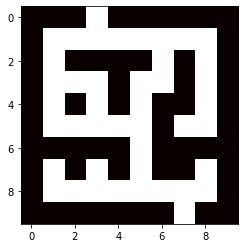

In [8]:
environment_rows = 10
environment_columns = 10
N = 10

rewards = np.full((environment_rows, environment_columns), -100.)

maze = {} 
maze[0] = [3]
maze[1] = [i for i in range(1,9)]
maze[2] = [1, 6, 8]
maze[3] = [1, 2, 3, 5, 6, 8]
maze[4] = [1, 3, 5, 8]
maze[5] = [1, 2, 3, 4, 5, 7, 8]
maze[6] = [5]
maze[7] = [1, 3, 5, 8]
maze[8] = [i for i in range(1,9)]

for row_index in range(0,N-1):
    for column_index in maze[row_index]:
        rewards[row_index, column_index] = -1
rewards[9, 7] = 100
        
for row in rewards:
    print(row)
    
data = np.zeros((environment_columns, environment_rows))
for j in range(environment_rows):
    for i in range(environment_columns):
        if rewards[j][i] == -100:
            data[j][i] = 0
        else:
            data[j][i] = 1

plt.imshow(data, interpolation='nearest', cmap='hot')

Episode:  0 Rewards-- min:  -500.0  max:  -500.0  avg:  -50.0  loss:  tf.Tensor(0.01120471, shape=(), dtype=float32)
Episode:  10 Rewards-- min:  -500.0  max:  -500.0  avg:  -500.0  loss:  tf.Tensor(5.160675e-06, shape=(), dtype=float32)
Episode:  20 Rewards-- min:  -500.0  max:  -500.0  avg:  -500.0  loss:  tf.Tensor(0.00095442706, shape=(), dtype=float32)
Episode:  30 Rewards-- min:  -500.0  max:  -500.0  avg:  -500.0  loss:  tf.Tensor(9.584366e-05, shape=(), dtype=float32)


KeyboardInterrupt: 

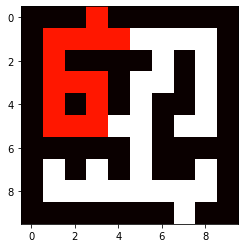

In [10]:
#define training parameters
N = environment_rows
discount_factor = 0.95
number_of_episodes = 1000
STEPS = 500
sampling_frequency = 10
epsilon = 0.99

#image pixel data
original_data = data.copy()
data_array = np.zeros((environment_rows, environment_columns, int(number_of_episodes/sampling_frequency) ))

#metrics sotrage arrays
reward_array = []
episode_array_for_minmaxavg = []
min_reward_array = [] 
max_reward_array = []
avg_reward_array = []
number_of_steps_array = []
loss_array = []
V=[]
for episode in range(number_of_episodes):
    row_index = 0
    column_index = 3 
    
    number_of_steps = 0
    aggr_reward = 0    
    while not is_terminal_state(row_index, column_index) and number_of_steps < STEPS:
        action, y_pred = get_next_action(row_index, column_index, epsilon)
        old_row_index, old_column_index, old_action, old_y_pred = row_index, column_index, action, y_pred
        old_state = np.array([[old_row_index, old_column_index]])
        row_index, column_index = get_next_location(old_row_index, old_column_index, action)
        
        state = np.array([[row_index, column_index]])
        reward = rewards[row_index, column_index]
        
        y_pred = model(state/(N-1))
        max_pred = np.max(y_pred,axis=1)
        value = reward + discount_factor * max_pred
        V.append(value.squeeze())
        value = value - np.mean(V)
        value = value / (np.std(V) + 0.0000001)
        
        y_target = old_y_pred.numpy().copy()
        y_target[0][old_action] = value
        
        loss, grads = loss_func(model,old_state/(N-1),y_target)
        opt.apply_gradients(zip(grads,model.trainable_variables))
                                        
        #metrics variables-------------------------------------------------------
        aggr_reward +=reward  
        number_of_steps += 1
        #------------------------------------------------------------------------
        
    if epsilon > 0.05:
        epsilon *= 0.999
        
    
    reward_array.append(aggr_reward)    
    number_of_steps_array.append(number_of_steps)
    loss_array.append(loss)
    
    if episode%sampling_frequency ==  0:
        index = int(episode / sampling_frequency)  
        draw_shortest_path()
        data_array[:,:,index] = data.copy()
        data = original_data.copy()
        
        average_reward = sum(reward_array[-sampling_frequency:])/sampling_frequency
        min_reward = min(reward_array[-sampling_frequency:])
        max_reward = max(reward_array[-sampling_frequency:])       
        print("Episode: ", episode,"Rewards-- min: ", min_reward ," max: ", max_reward, " avg: ", average_reward, " loss: ", loss)

        episode_array_for_minmaxavg.append(episode)
        min_reward_array.append(min_reward)
        max_reward_array.append(max_reward)
        avg_reward_array.append(average_reward)
    

print('Training complete!')

In [ ]:
fig=plt.figure(figsize=(30, 30))
columns = 10
rows = int(number_of_episodes / columns / sampling_frequency)
for i in range(1, columns*rows +1):
    img = data_array[:,:,i-1]
    fig.add_subplot(rows, columns, i)    
    plt.imshow(img, interpolation='nearest', cmap='hot')
plt.show()

In [ ]:
fig=plt.figure(figsize=(16, 10))
plt.plot(reward_array,  label="Reward" )
plt.ylim(-200, 100)
plt.title("Rewards per episode")
plt.legend(loc=2)
plt.show()

In [ ]:
fig=plt.figure(figsize=(16, 10))
plt.plot(episode_array_for_minmaxavg, min_reward_array, label="Min" )
plt.plot(episode_array_for_minmaxavg, max_reward_array, label="Max" )
plt.plot(episode_array_for_minmaxavg, avg_reward_array, label="Avg" )
plt.title("Reward MIN MAX AVG per episode")
plt.ylim(-200, 100)
plt.legend(loc=2)
plt.show()

In [ ]:
fig=plt.figure(figsize=(16, 10))
plt.plot(number_of_steps_array,  label="Number of steps" )
plt.title("Number of steps per episode")
plt.ylim(-50, 100)
plt.legend(loc=2)
plt.show()

In [ ]:
fig=plt.figure(figsize=(16, 10))
plt.plot(loss_array,  label="Loss" )
plt.title("Loss per episode")
plt.legend(loc=2)
plt.show()